In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Redes Neurais: Séries Temporais

Autor:
- Larissa Ionafa RA:1903166
- Roberta Yumi Romero Takahashi RA:1903220

## Lendo as bibliotecas

In [2]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Bases/POP.csv',index_col='date')
train.tail()

,realtime_start,value,realtime_end
date,,,
2019-08-01,2019-12-06,329591.333,2019-12-06
2019-09-01,2019-12-06,329785.872,2019-12-06
2019-10-01,2019-12-06,329982.035,2019-12-06
2019-11-01,2019-12-06,330154.949,2019-12-06
2019-12-01,2019-12-06,330309.946,2019-12-06


In [4]:
train.index = pd.to_datetime(train.index)

In [5]:
# Definindo separação da base de treino pra 70% e teste 30%
cut_point = int(len(train) * 0.7)
train, test = train.iloc[:cut_point], train.iloc[cut_point:]

In [6]:
time_series_full = pd.concat([train,test])
time_series_full

,realtime_start,value,realtime_end
date,,,
1952-01-01,2019-12-06,156309.000,2019-12-06
1952-02-01,2019-12-06,156527.000,2019-12-06
1952-03-01,2019-12-06,156731.000,2019-12-06
1952-04-01,2019-12-06,156943.000,2019-12-06
1952-05-01,2019-12-06,157140.000,2019-12-06
...,...,...,...
2019-08-01,2019-12-06,329591.333,2019-12-06
2019-09-01,2019-12-06,329785.872,2019-12-06
2019-10-01,2019-12-06,329982.035,2019-12-06


# Criando Defasagens (lags)

São valores passados da série temporal em relação ao valor atual. Para a base da temperatura, ela pode ser explicada com os dados umidade (humidity), velocidade do vento (wind speed) e pressão atmosférica média (mean pressure).

Entretanto, em muitos estudos de série temporal, não temos variáveis explicativas além da própria série alvo (histórico da variável resposta). Nesse cenário, usamos o próprio histórico da série como variável explicativa. Para isso, usamos observações anteriores para explicar o comportamento atual da série.

In [7]:
time_series_full['value_1lag'] = [0]+list(time_series_full['value'].values)[:-1]
time_series_full['value_2lag'] = [0,0]+list(time_series_full['value'].values)[:-2]
time_series_full['value_3lag'] = [0,0,0]+list(time_series_full['value'].values)[:-3]
time_series_full['value_4lag'] = [0,0,0,0]+list(time_series_full['value'].values)[:-4]
time_series_full['value_5lag'] = [0,0,0,0,0]+list(time_series_full['value'].values)[:-5]

In [8]:
time_series_full.head(7)

,realtime_start,value,realtime_end,value_1lag,value_2lag,value_3lag,value_4lag,value_5lag
date,,,,,,,,
1952-01-01,2019-12-06,156309.0,2019-12-06,0.0,0.0,0.0,0.0,0.0
1952-02-01,2019-12-06,156527.0,2019-12-06,156309.0,0.0,0.0,0.0,0.0
1952-03-01,2019-12-06,156731.0,2019-12-06,156527.0,156309.0,0.0,0.0,0.0
1952-04-01,2019-12-06,156943.0,2019-12-06,156731.0,156527.0,156309.0,0.0,0.0
1952-05-01,2019-12-06,157140.0,2019-12-06,156943.0,156731.0,156527.0,156309.0,0.0
1952-06-01,2019-12-06,157343.0,2019-12-06,157140.0,156943.0,156731.0,156527.0,156309.0
1952-07-01,2019-12-06,157553.0,2019-12-06,157343.0,157140.0,156943.0,156731.0,156527.0


**Contextualizando**
No dia 01/01/2013 (primeira linha), a temperatura era igual a 10.

Com uma defasagem, vamos usar a temperatura do dia 01/01/2013 para explicar a temperatura do próximo dia: 02/01/2013. Portanto, a coluna *meantemp_1lag* consta com o valor 10 (temperatura do dia 01/01/2013) no dia 02/01/2013. Afinal, a ideia consiste em usar a temperatura do dia anterior para explicar a temperatura da data atual (considerando a data atual sendo 02/01/2013).

É importante ressaltar que: **a quantidade de defasagem corresponde a quantidade de linhas da fonte de dados que vamos desconsiderar**. Note que na coluna meantemp_1lag, o primeiro valor é 0, pois não temos dados anteriores a 01/01/2013. Já na coluna *meantemp_5lag*, os 5 primeiros valores são 0, visto que não temos os dados dos primeiros 5 dias.

Logo, será necessário remover as 5 primeiras linhas da tabela, se optarmos por utilizar 5 defasagens como variáveis explicativas.

In [10]:
print(len(time_series_full))
time_series_full = time_series_full.loc[(time_series_full.value_5lag > 0)]
print(len(time_series_full))

816
811


In [11]:
len(train.index)

571

In [12]:
train = time_series_full.loc[(time_series_full.index.isin(train.index))]
train.tail()

,realtime_start,value,realtime_end,value_1lag,value_2lag,value_3lag,value_4lag,value_5lag
date,,,,,,,,
1999-03-01,2019-12-06,278198.0,2019-12-06,277992.0,277790.0,277526.0,277277.0,277003.0
1999-04-01,2019-12-06,278451.0,2019-12-06,278198.0,277992.0,277790.0,277526.0,277277.0
1999-05-01,2019-12-06,278717.0,2019-12-06,278451.0,278198.0,277992.0,277790.0,277526.0
1999-06-01,2019-12-06,279001.0,2019-12-06,278717.0,278451.0,278198.0,277992.0,277790.0
1999-07-01,2019-12-06,279295.0,2019-12-06,279001.0,278717.0,278451.0,278198.0,277992.0


In [13]:
test = time_series_full.loc[(time_series_full.index.isin(test.index))]
test.tail()

,realtime_start,value,realtime_end,value_1lag,value_2lag,value_3lag,value_4lag,value_5lag
date,,,,,,,,
2019-08-01,2019-12-06,329591.333,2019-12-06,329394.993,329213.989,329047.319,328890.250,328742.843
2019-09-01,2019-12-06,329785.872,2019-12-06,329591.333,329394.993,329213.989,329047.319,328890.250
2019-10-01,2019-12-06,329982.035,2019-12-06,329785.872,329591.333,329394.993,329213.989,329047.319
2019-11-01,2019-12-06,330154.949,2019-12-06,329982.035,329785.872,329591.333,329394.993,329213.989
2019-12-01,2019-12-06,330309.946,2019-12-06,330154.949,329982.035,329785.872,329591.333,329394.993


# Modelagem de Séries Temporais

### Rede Neural LSTM

A arquitetura LSTM de rede neural funciona a partir das unidades. Cada unidade é como se fosse um neurônio que é conectado ao outro de maneira sequencial:

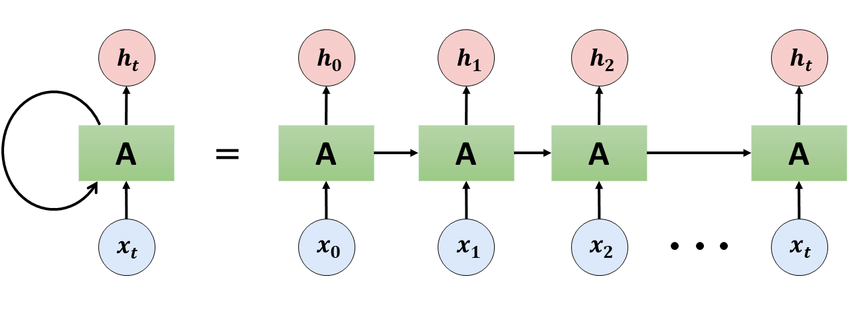

No exemplo acima, a gente compreende o motivo dessa rede ser Recorrente. Ou seja, o primeiro neurônio recebe uma entrada e gera uma saída. Essa saída é utilizada pelo neurônio seguinte, ao longo do tempo.

A arquitetura LSTM usa esse princípio combinando com particularidades extra:

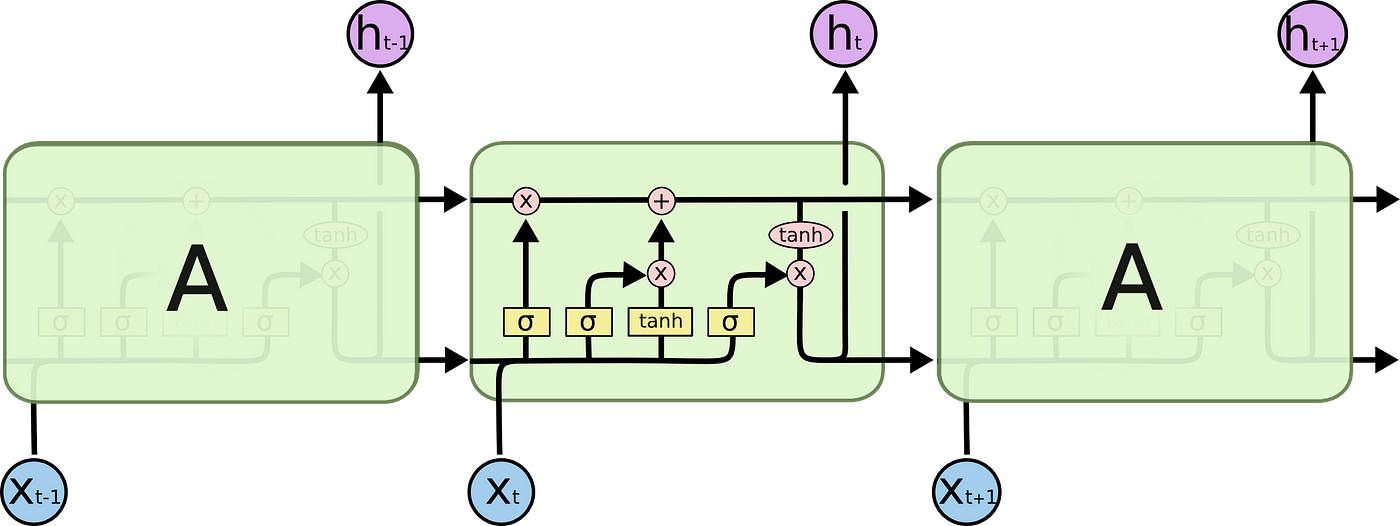

Na imagem acima, temos o seguinte exemplo:

O "X" do tempo anterior (t-1) é a entrada da unidade. Há a arquitetura da rede neural LSTM que analisa a entrada e gera 3 saídas. h(t-1) e mais duas saídas. A saída h (t-1) é uma parte do conhecimento da rede neural que será descartada. Já as outras duas saídas representadas pelas setas, seguem conectadas a próxima unidade da rede neural que vai receber a variável X (t). Portanto, é importante notar que além de receber a variável X no momento posterior, esse neurônio/unidade recebe também a experiência obtida no momento anterior (t-1).

Se observarmos uma unidade isoladamente, fica claro o que é recebido, "esquecido" e passado para a próxima unidade:

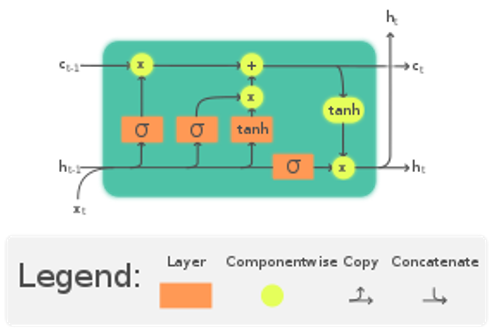

* Ct-1: é o output gerado pela unidade anterior e é aproveitado pela unidade atual;
* Ht-1: é o output gerado pela unidade anterior que é vinculado ao X atual e analisado pela unidade atual;
* H t: é o conhecimento gerado pela unidade. Uma parte dele é esquecido e outra parte é levada adiante;
* C t: é outro output gerado pela unidade LSTM que será utilizado na próxima unidade;
* A parte laranja são funções de ativação. Tangentes e sigmoids.
* A parte amarela envolve os vetores com valores e uma função de ativação tangente.

In [14]:
# Passo 1: separando X e Y e normalizando os dados

X = train[['value_1lag',	'value_2lag',	'value_3lag',	'value_4lag',	'value_5lag']]
y = train["value"]

# Normalização dos dados
# Normalize os dados (opcional, mas pode melhorar o desempenho da rede)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Converta os dados para o formato 3D esperado pela LSTM (samples, timesteps, features)
# Nesse caso, como temos apenas uma variável explicativa (3 features), definimos timesteps = 1.
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

In [15]:
len(X),len(y)

(566, 566)

In [16]:
X_lstm.shape #1462 linhas na base, por 1 data, com 3 variáveis explicativas em cada data

(566, 1, 5)

### LSTM: Modelo 1

In [17]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model1 = Sequential()
model1.add(LSTM(units=50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model1.add(Dense(units=1))

# Passo 3: Compile o modelo

model1.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history1 = model1.fit(X_lstm, y_scaled, epochs=200, batch_size=32)

Epoch 1/200
18/18 [==============================] - 2s 4ms/step - loss: 0.3203
Epoch 2/200
18/18 [==============================] - 0s 3ms/step - loss: 0.2238
Epoch 3/200
18/18 [==============================] - 0s 3ms/step - loss: 0.1472
Epoch 4/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 5/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0275
Epoch 6/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 7/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 8/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 9/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 10/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 11/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 12/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 13/200
18/18 [=================

### LSTM: Modelo 2

In [18]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model2 = Sequential()
model2.add(LSTM(units=100, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model2.add(Dense(units=1))

# Passo 3: Compile o modelo

model2.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history2 = model2.fit(X_lstm, y_scaled, epochs=200, batch_size=32)

Epoch 1/200
18/18 [==============================] - 2s 4ms/step - loss: 0.2302
Epoch 2/200
18/18 [==============================] - 0s 3ms/step - loss: 0.1166
Epoch 3/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0363
Epoch 4/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 5/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 6/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 7/200
18/18 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 8/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 9/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 10/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 11/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 12/200
18/18 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 13/200
18/18 [=================

### LSTM: Modelo 3

In [19]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model3 = Sequential()
model3.add(LSTM(units=100, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model3.add(Dense(units=1))

# Passo 3: Compile o modelo

model3.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history3 = model3.fit(X_lstm, y_scaled, epochs=200, batch_size=128)

Epoch 1/200
5/5 [==============================] - 1s 6ms/step - loss: 0.3325
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2941
Epoch 3/200
5/5 [==============================] - 0s 5ms/step - loss: 0.2591
Epoch 4/200
5/5 [==============================] - 0s 5ms/step - loss: 0.2272
Epoch 5/200
5/5 [==============================] - 0s 5ms/step - loss: 0.1967
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1696
Epoch 7/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1437
Epoch 8/200
5/5 [==============================] - 0s 5ms/step - loss: 0.1198
Epoch 9/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0965
Epoch 10/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0748
Epoch 11/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0560
Epoch 12/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 13/200
5/5 [==============================] - 0s 5ms/st

### Comparando a Loss

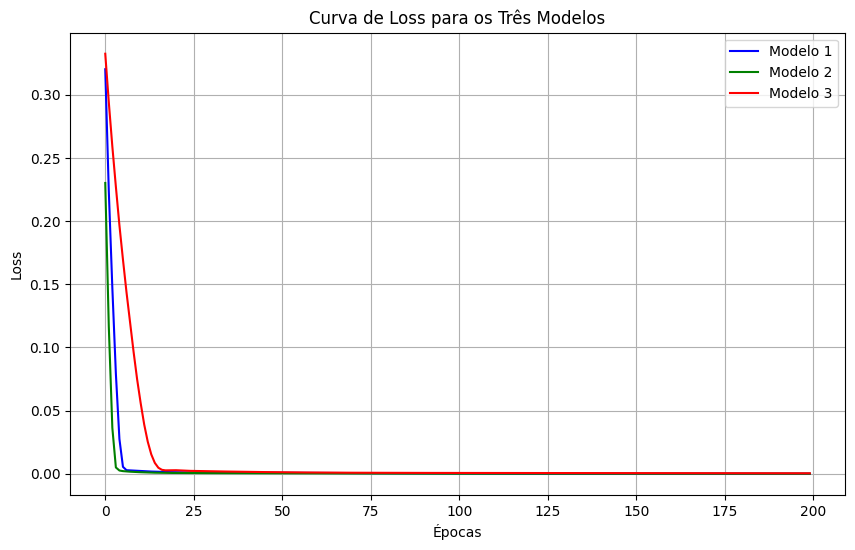

In [20]:
# Supondo que você tenha os objetos "history1", "history2" e "history3", que contêm informações sobre o treinamento dos três modelos.

# Plotando as curvas de loss
plt.figure(figsize=(10, 6))

plt.plot(history1.history['loss'], label='Modelo 1', color='blue')
plt.plot(history2.history['loss'], label='Modelo 2', color='green')
plt.plot(history3.history['loss'], label='Modelo 3', color='red')

plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Loss para os Três Modelos')
plt.legend()
plt.grid(True)
plt.show()

### Avaliando a base de teste

In [21]:
# Passo 1: Pré-processamento dos novos dados de teste

# Divida os dados em variáveis de entrada (X) e variável de saída (y), similar ao que você fez para os dados de treinamento.
X_test = test[['value_1lag',	'value_2lag',	'value_3lag',	'value_4lag',	'value_5lag']]

# Normalize os dados usando o mesmo scaler que você usou para os dados de treinamento.
X_test_scaled = scaler_X.transform(X_test)

# Converta os dados para o formato 3D esperado pela LSTM
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Passo 2: Fazer previsões com o modelo LSTM

# Use o método predict para fazer as previsões
y_pred_scaled1 = model1.predict(X_test_lstm)
y_pred_scaled2 = model2.predict(X_test_lstm)
y_pred_scaled3 = model3.predict(X_test_lstm)

# Como o modelo retorna as previsões em escala, desfaça a normalização para obter as previsões reais
y_pred1 = scaler_y.inverse_transform(y_pred_scaled1)
y_pred2 = scaler_y.inverse_transform(y_pred_scaled2)
y_pred3 = scaler_y.inverse_transform(y_pred_scaled3)

8/8 [==============================] - 0s 3ms/step


No exemplo anterior, usando umidade, pressão atmosférica e velocidade do vento, o resultado foi:

* RMSE Modelo 1: 9.518648288930006
* RMSE Modelo 2: 9.382544234222491
* RMSE Modelo 3: 9.306333916727356
* RMSE do AutoARIMA: 10.649383525981344

In [22]:
# Calcule o RMSE para cada modelo
rmse_model1 = np.sqrt(np.mean((np.array(test['value']) - y_pred1) ** 2))
rmse_model2 = np.sqrt(np.mean((np.array(test['value']) - y_pred2) ** 2))
rmse_model3 = np.sqrt(np.mean((np.array(test['value']) - y_pred3) ** 2))

print('RMSE Modelo 1:', rmse_model1)
print('RMSE Modelo 2:', rmse_model2)
print('RMSE Modelo 3:', rmse_model3)

RMSE Modelo 1: 21271.721281526698
RMSE Modelo 2: 21083.52238548942
RMSE Modelo 3: 28649.704275214433


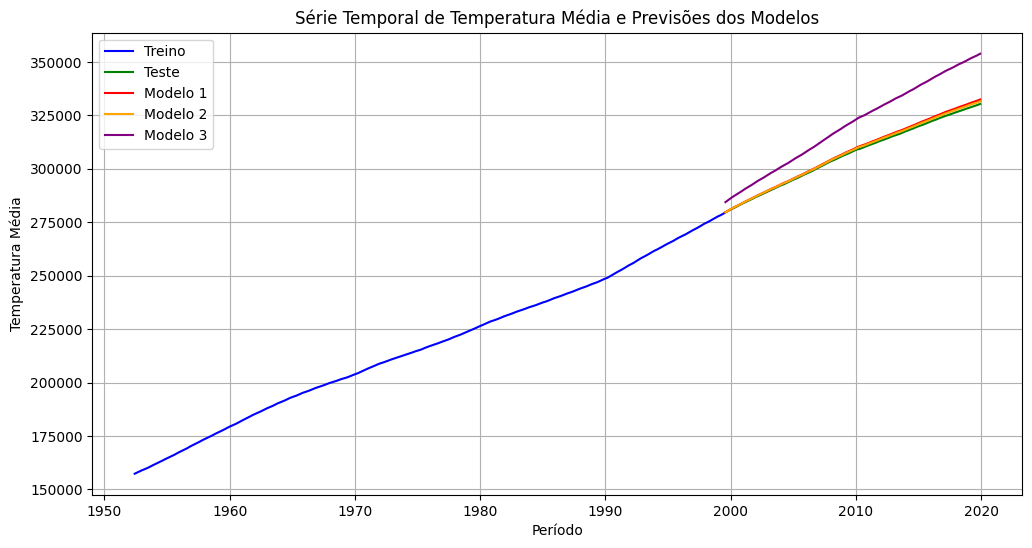

In [23]:
# Plotando a série temporal da coluna "value" da base de treino e teste
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['value'], label='Treino', color='blue')
plt.plot(test.index, test['value'], label='Teste', color='green')

# Plotando as previsões dos modelos em cores diferentes
plt.plot(test.index, y_pred1, label='Modelo 1', color='red')
plt.plot(test.index, y_pred2, label='Modelo 2', color='orange')
plt.plot(test.index, y_pred3, label='Modelo 3', color='purple')

plt.xlabel('Período')
plt.ylabel('Temperatura Média')
plt.title('Série Temporal de Temperatura Média e Previsões dos Modelos')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [24]:
test['Modelo 1'] = y_pred1
test['Modelo 2'] = y_pred2
test['Modelo 3'] = y_pred3

test

<ipython-input-24-f95dbaf015c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Modelo 1'] = y_pred1
<ipython-input-24-f95dbaf015c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Modelo 2'] = y_pred2
<ipython-input-24-f95dbaf015c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,realtime_start,value,realtime_end,value_1lag,value_2lag,value_3lag,value_4lag,value_5lag,Modelo 1,Modelo 2,Modelo 3
date,,,,,,,,,,,
1999-08-01,2019-12-06,279602.000,2019-12-06,279295.000,279001.000,278717.000,278451.000,278198.000,279654.87500,279634.71875,284410.62500
1999-09-01,2019-12-06,279903.000,2019-12-06,279602.000,279295.000,279001.000,278717.000,278451.000,279938.62500,279918.21875,284762.03125
1999-10-01,2019-12-06,280203.000,2019-12-06,279903.000,279602.000,279295.000,279001.000,278717.000,280231.90625,280211.43750,285125.93750
1999-11-01,2019-12-06,280471.000,2019-12-06,280203.000,279903.000,279602.000,279295.000,279001.000,280533.15625,280511.68750,285498.81250
1999-12-01,2019-12-06,280716.000,2019-12-06,280471.000,280203.000,279903.000,279602.000,279295.000,280831.06250,280808.84375,285868.15625
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,2019-12-06,329591.333,2019-12-06,329394.993,329213.989,329047.319,328890.250,328742.843,331652.46875,330818.15625,352779.34375
2019-09-01,2019-12-06,329785.872,2019-12-06,329591.333,329394.993,329213.989,329047.319,328890.250,331830.59375,330991.18750,353027.68750
2019-10-01,2019-12-06,329982.035,2019-12-06,329785.872,329591.333,329394.993,329213.989,329047.319,332018.15625,331173.84375,353290.56250


### AutoSarima

In [25]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00


In [26]:
import pmdarima as pm

In [27]:
# Crie o modelo AutoARIMA e encontre o melhor modelo ARIMA automaticamente
model4 = pm.auto_arima(np.array(train['value']), exogenous=np.array(train[['value_1lag',	'value_2lag',	'value_3lag',	'value_4lag',	'value_5lag']]), seasonal=True, m=7)  # O parâmetro "m" representa a frequência da sazonalidade (7 dias por semana)

# Faça as previsões usando o modelo treinado
y_pred4 = model4.predict(n_periods=len(np.array(test['value'])), exogenous=np.array(test[['value_1lag',	'value_2lag',	'value_3lag',	'value_4lag',	'value_5lag']]))

In [28]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  566
Model:             SARIMAX(1, 2, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -2493.361
Date:                                Tue, 24 Oct 2023   AIC                           4998.722
Time:                                        00:55:11   BIC                           5024.732
Sample:                                             0   HQIC                          5008.875
                                                - 566                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6264      0.045     13.860      0.000       0.538       0.715
ma.L1         -0.9085      0.029    -30.910      0.000      -0.966      -0.851
ar.S.L7       -0.1982      0.153     -1.295      0.195      -0.498       0.102
ma.S.L7       -0.0734      0.156     -0.469      0.639      -0.380       0.233
ma.S.L14       0.2388      0.058      4.114      0.000       0.125       0.353
sigma2       399.3130     14.262     27.998      0.000     371.360     427.266
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               824.39
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.75
Prob(H) (two-sided):                  0.24   Kurtosis:                         8.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Calcule o RMSE para avaliar o desempenho do modelo
rmse = mean_squared_error(np.array(test['value']), y_pred4, squared=False)
print(f"RMSE do AutoARIMA: {rmse}")

RMSE do AutoARIMA: 7126.256903027492


# Conclusão

No exemplo anterior, usando umidade, pressão atmosférica e velocidade do vento, o resultado foi:

* RMSE Modelo 1: 9.518648288930006
* RMSE Modelo 2: 9.382544234222491
* RMSE Modelo 3: 9.306333916727356
* RMSE do AutoARIMA: 10.649383525981344

Usando a própria série com defasagens para explicar seu comportamento, obtivemos:

* RMSE Modelo 1: 8.838807165368115
* RMSE Modelo 2: 8.962550532868478
* RMSE Modelo 3: 8.844388155644248
* RMSE do AutoARIMA: 9.084805494202321

Portanto, **nesse estudo de caso**, a defasagem contribuiu para que a predição fosse melhor. Isso não é uma regra.

Há a oportunidade de testar as variáveis exógenas e a própria série (com defasagens) para explicar seu comportamento. Vale ressaltar que se houver muita correlação, pode não haver ganhos significativos.